# Modeling the Bank Marketing Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [4]:
df = pd.read_csv('data/bank_data.csv', sep=';')

In [5]:
df['y'] = df['y'].map({'no': 0, 'yes': 1})

## Let's build pipelines for numeric and categorical features

In [6]:
num_feat = df.drop('y', axis=1).select_dtypes(include=np.number).columns
cat_feat = df.drop('y', axis=1).select_dtypes(include=['object']).columns
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) # Another Option: ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_feat),
        ('cat', categorical_transformer, cat_feat)
    ])

## Let's use a simple model to check if the pipeline is working fine

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',  LogisticRegression(class_weight='balanced', random_state=0))
])

model = pipe.fit(X_train, y_train)
#target_names = y_test.unique().astype(str)
y_pred = model.predict(X_test)

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7269
           1       0.45      0.89      0.60       969

    accuracy                           0.86      8238
   macro avg       0.72      0.87      0.76      8238
weighted avg       0.92      0.86      0.88      8238



In [12]:
print(round(pd.DataFrame(confusion_matrix(y_test, y_pred)/len(y_test)*1e2)))

      0     1
0  75.0  13.0
1   1.0  11.0


## Let's analyze multiple models

In [13]:
from time import time
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis, 
                                           QuadraticDiscriminantAnalysis) 
from sklearn.linear_model import (LogisticRegression, RidgeClassifier, 
                                  SGDClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier)
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [14]:
results = pd.DataFrame(columns=['Name', 'AUC', 'Gini', 'StdDev(%)', 'Time(s)'])

for model in [
    DummyClassifier,
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
    LogisticRegression, 
    RidgeClassifier,
    SGDClassifier,
    DecisionTreeClassifier,
    RandomForestClassifier, 
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    MLPClassifier,
    XGBClassifier,
    LGBMClassifier
]:
    pipe = make_pipeline(preprocessor, model())
    start_time = time()
    kfold = StratifiedKFold(n_splits=5, random_state=1)
    scores = cross_val_score(pipe, X_train, 
                             y_train, scoring='roc_auc', cv=kfold)
    time_mod = time() - start_time
    results = results.append({
        'Name' : model.__name__, 
        'AUC' : round(scores.mean(), 2), 
        'Gini' : round(2*scores.mean()-1, 2), 
        'StdDev(%)' : round(1e2*scores.std(), 2), 
        'Time(s)': round(time_mod, 2)
    }, ignore_index=True)
    del pipe
    print('Analyzed {}.'.format(model.__name__))
print('Done!')

results = results.sort_values('Gini', ascending=False)

Analyzed DummyClassifier.
Analyzed LinearDiscriminantAnalysis.
Analyzed QuadraticDiscriminantAnalysis.
Analyzed LogisticRegression.
Analyzed RidgeClassifier.
Analyzed SGDClassifier.
Analyzed DecisionTreeClassifier.
Analyzed RandomForestClassifier.
Analyzed GradientBoostingClassifier.
Analyzed ExtraTreesClassifier.
Analyzed MLPClassifier.
Analyzed XGBClassifier.
Analyzed LGBMClassifier.
Done!


In [15]:
results

,Name,AUC,Gini,StdDev(%),Time(s)
12,LGBMClassifier,0.95,0.90,0.16,7.82
8,GradientBoostingClassifier,0.95,0.89,0.24,70.21
11,XGBClassifier,0.95,0.89,0.24,38.38
7,RandomForestClassifier,0.94,0.88,0.28,25.13
1,LinearDiscriminantAnalysis,0.93,0.87,0.35,3.28
3,LogisticRegression,0.94,0.87,0.28,5.10
4,RidgeClassifier,0.93,0.87,0.35,1.73
10,MLPClassifier,0.92,0.85,0.43,243.56
5,SGDClassifier,0.92,0.84,0.73,2.94
9,ExtraTreesClassifier,0.91,0.82,0.51,28.87


## Let's use Lightgbm Model in a pipeline

In [16]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lgbm',  LGBMClassifier())
])

model = pipe.fit(X_train, y_train)
target_names = y_test.unique().astype(str)
y_pred = model.predict(X_test)

In [17]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7269
           1       0.65      0.54      0.59       969

    accuracy                           0.91      8238
   macro avg       0.80      0.75      0.77      8238
weighted avg       0.91      0.91      0.91      8238



In [18]:
print(round(pd.DataFrame(confusion_matrix(y_test, y_pred)/len(y_test)*1e2)))

      0    1
0  85.0  3.0
1   5.0  6.0


## Performance of the Model

In [19]:
from yellowbrick.classifier import ConfusionMatrix, ROCAUC, PrecisionRecallCurve, DiscriminationThreshold
from yellowbrick.model_selection import LearningCurve
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve

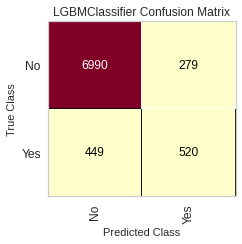

In [20]:
mapping = {0:'No', 1:'Yes'}
fig, ax = plt.subplots(figsize=(3, 3))
cm_viz = ConfusionMatrix(model, classes=['No', 'Yes'], label_encoder=mapping)
cm_viz.score(X_test, y_test)
cm_viz.poof()
plt.show()

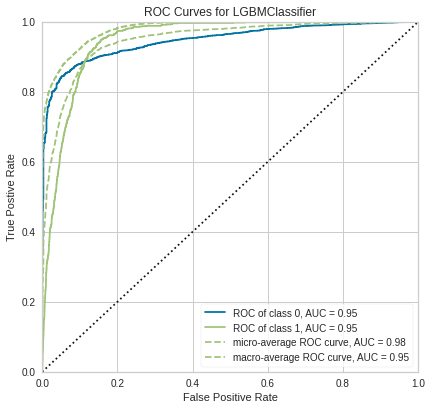

In [21]:
fig, ax = plt.subplots(figsize=(6,6))
roc_viz = ROCAUC(model)
roc_viz.score(X_test, y_test)
roc_viz.poof()
plt.show()

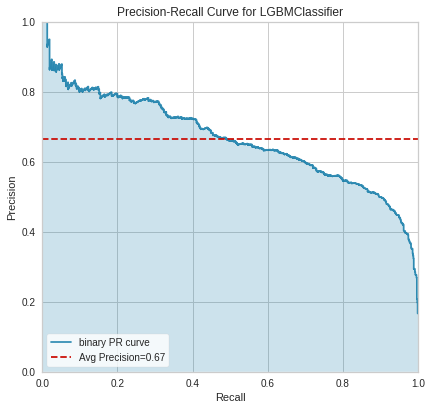

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
pr_viz = PrecisionRecallCurve(model)
pr_viz.fit(X_train, y_train)
pr_viz.score(X_test, y_test)
pr_viz.poof()
plt.show()

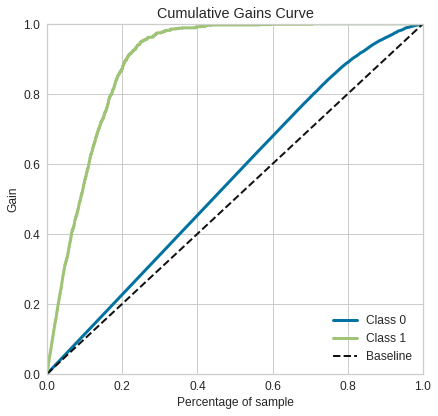

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
y_probas = model.predict_proba(X_test)
plot_cumulative_gain(y_test, y_probas, ax=ax);

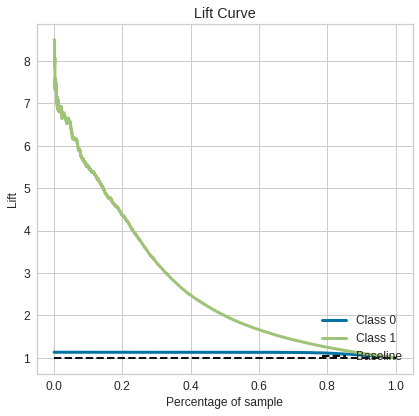

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_lift_curve(y_test, y_probas, ax=ax);

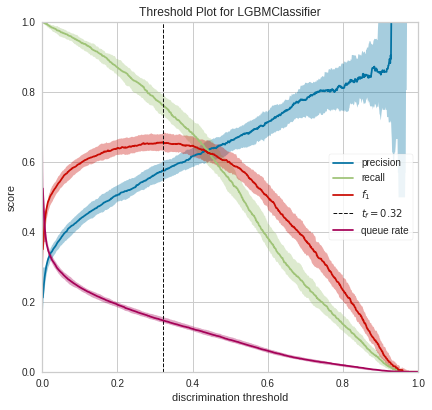

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))
model_viz = DiscriminationThreshold(model)
model_viz.fit(X_train, y_train)
model_viz.poof();

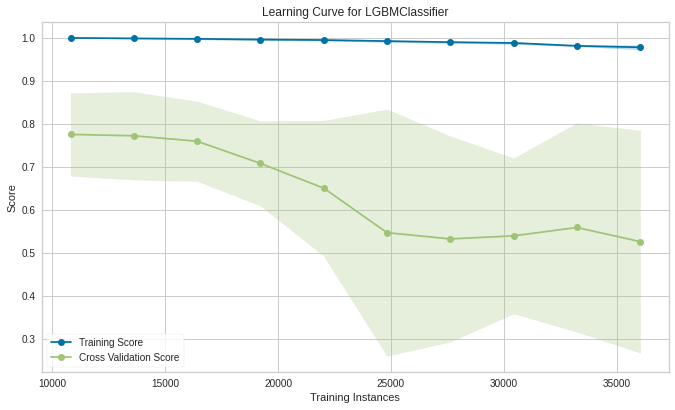

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
cv = StratifiedKFold(8)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = LearningCurve(model, cv=cv, train_sizes=sizes, scoring='roc_auc', n_jobs=4, ax=ax)
lc_viz.fit(X, y)
lc_viz.poof();

## Default parameters of LGBMClassifier


### Core parameters
1. num_iterations (100) 
2. learning_rate (0.1) 
3. num_leaves (31)

### Learning Control Parameters
4. max_depth (-1)
5. min_data_in_leaf (20)
6. bagging_fraction (1.0)
7. feature_fraction (1.0)

In [27]:
param_grid = {
    'lgbm__num_iterations': [2, 100, 200],
    'lgbm__learning_rate': [0.01, 0.1, 1],
    'lgbm__num_leaves': [3, 31, 301],
    'lgbm__max_depth': [-1, 10, 100],
}

In [28]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.92
Test set score: 0.91
Best parameters: {'lgbm__learning_rate': 0.1, 'lgbm__max_depth': -1, 'lgbm__num_iterations': 100, 'lgbm__num_leaves': 31}
